In [1]:
import statsmodels.api as sm

In [2]:
def getMonth(index):
    return pd.datetime.strftime(index,'%m')

In [3]:
# set elevations
elevations = {'Vcm':3003.0,'Jemez RAWS':2514.0}

In [4]:
delz = elevations['Vcm'] - elevations['Jemez RAWS']

In [5]:
lapse = pd.read_pickle('./data/jemez_vcm_lapse.pcl') # load the monthly lapse rates
jemez = pd.read_pickle('./data/Jemez_raws_wy2003_2015.pcl') # load the met data
mod1 = sm.load('./data/rain_duration_model.mod') # load the precip amount, rain duration model

In [6]:
jemez['month'] = jemez.index.map(getMonth) # compute months

In [7]:
## Generate the Vcm_tmin
def gen_tmin(df):
    m = df['month']
    lr = lapse.loc[m,'tmin']
    return (df['Tmin'] + (delz * lr))

def gen_tave(df):
    m = df['month']
    lr = lapse.loc[m,'tave']
    return (df['Tave'] + (delz * lr))
    
def gen_tmax(df):
    m = df['month']
    lr = lapse.loc[m,'tmax']
    return (df['Tmax'] + (delz * lr))
    
def gen_p(df):
    m = df['month']
    lr = lapse.loc[m,'Pclean']
    return (df['P'] + (delz * lr))

In [8]:
jemez['Vcm_tmin'] = jemez.apply(gen_tmin,axis=1)
jemez['Vcm_tave'] = jemez.apply(gen_tave,axis=1)
jemez['Vcm_tmax'] = jemez.apply(gen_tmax,axis=1)
jemez['Vcm_p'] = jemez.apply(gen_p,axis=1)

In [9]:
jemez.loc[jemez.Vcm_p<0,'Vcm_p'] = 0

In [10]:
jemez['Vcm_rain_duration'] = (jemez.Vcm_p*mod1.params['P'])+((jemez.Vcm_p**2)*mod1.params['P2'])+mod1.params['Intercept']

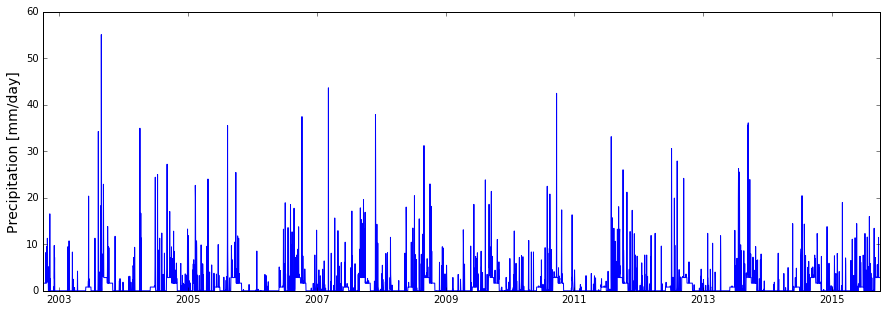

In [11]:
plt.figure(figsize=(15,5))
plt.plot(jemez.index,jemez.Vcm_p)
plt.ylabel('Precipitation [mm/day]', fontsize=14)

In [12]:
## Set the rain duration to 1 hour for the monsoon season

for year in np.unique(jemez.index.year):
    strt = '%s-06-15'%year
    nd = '%s-09-15'%year
    
    jemez.loc[(jemez.index>=strt) & (jemez.index<=nd) & (jemez.Vcm_p>0),'Vcm_rain_duration'] = 1

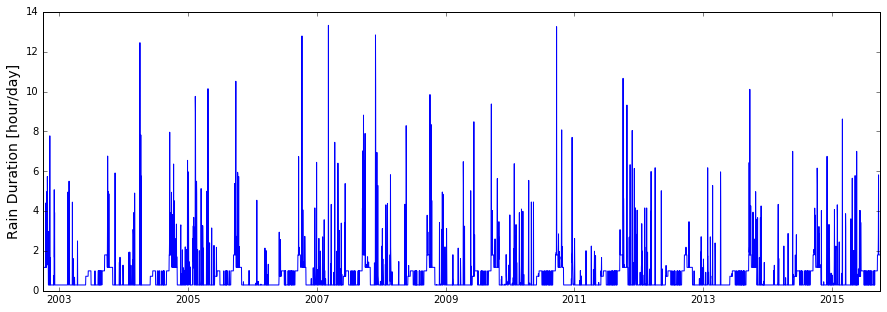

In [13]:
plt.figure(figsize=(15,5))
plt.plot(jemez.index,jemez.Vcm_rain_duration)
plt.ylabel('Rain Duration [hour/day]',fontsize=14)

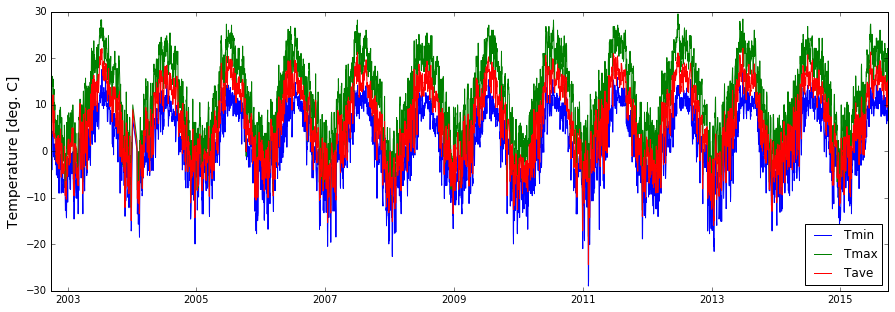

In [14]:
plt.figure(figsize=(15,5))
plt.plot(jemez.index,jemez.Vcm_tmin,label = 'Tmin')
plt.plot(jemez.index,jemez.Vcm_tmax,label = 'Tmax')
plt.plot(jemez.index,jemez.Vcm_tave,label = 'Tave')
plt.legend(loc='lower right')
plt.ylabel('Temperature [deg. C]', fontsize=14)

In [15]:
jemez.loc[(jemez.Vcm_tmin>jemez.Vcm_tmax) | (jemez.Vcm_tmin>jemez.Vcm_tave) | (jemez.Vcm_tave>jemez.Vcm_tmax)].shape

(87, 14)

In [16]:
jemez.loc[(jemez.Vcm_tmin>jemez.Vcm_tmax) | (jemez.Vcm_tmin>jemez.Vcm_tave) | (jemez.Vcm_tave>jemez.Vcm_tmax),['Vcm_tmin','Vcm_tmax','Vcm_tave']] = np.NaN 

In [17]:
jemez.interpolate(inplace=True)

In [18]:
print jemez.index.min()
print jemez.index.max()

2002-10-01 00:00:00
2015-09-30 00:00:00


In [19]:
head = '2002 10 1'

np.savetxt('/RHESSys/jemez/clim/Vcm.tmax',jemez.Vcm_tmax.as_matrix(),fmt = '%f', comments='',header=head)
np.savetxt('/RHESSys/jemez/clim/Vcm.tmin',jemez.Vcm_tmin.as_matrix(),fmt = '%f', comments='',header=head)
np.savetxt('/RHESSys/jemez/clim/Vcm.tavg',jemez.Vcm_tave.as_matrix(),fmt = '%f', comments='',header=head)
np.savetxt('/RHESSys/jemez/clim/Vcm.rain',(jemez.Vcm_p).as_matrix()/1000.,fmt = '%f', comments='',header=head)
np.savetxt('/RHESSys/jemez/clim/Vcm.daytime_rain_duration',jemez.Vcm_rain_duration.as_matrix(),fmt = '%f', comments='',header=head)

In [18]:
jemez.to_pickle('./data/jemez_raws_lapse.pcl')